Neural network metamodel which takes information from bookmakers model, Poisson model and data enrichment and tries to predict the draws.

* Input: "predictions_joined_enriched.csv"
* Ouput: None

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score

import tensorflow as tf
print(tf.__version__)

2022-11-29 23:04:08.540912: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-29 23:04:09.048540: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-11-29 23:04:09.048571: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-29 23:04:09.130072: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-29 23:04:10.573955: W tensorflow/stream_executor/platform/de

2.10.0


# Reading data

In [2]:
df_read = pd.read_csv('./data/predictions_joined_enriched.csv', sep=';', parse_dates=['date'], low_memory=False)
df_read

,date,team_home,team_away,goals_home,goals_away,probability_home_poisson,probability_draw_poisson,probability_away_poisson,prediction_poisson,observation,is_true_poisson,probability_home_bookmaker,probability_draw_bookmaker,probability_away_bookmaker,prediction_bookmaker,is_true_bookmaker,season_progress,distance
0,2013-08-17,Sociedad,Getafe,2,0,0.674,0.186,0.132,home,home,1.0,0.578,0.278,0.211,home,1,0.0,361
1,2013-08-17,Valencia,Malaga,1,0,0.594,0.211,0.190,home,home,1.0,0.654,0.250,0.167,home,1,0.0,469
2,2013-08-17,Valladolid,Ath Bilbao,1,2,0.505,0.230,0.261,home,away,0.0,0.400,0.303,0.357,home,0,0.0,234
3,2013-08-18,Barcelona,Levante,7,0,0.826,0.082,0.036,home,home,1.0,0.926,0.100,0.038,home,1,0.0,297
4,2013-08-18,Osasuna,Granada,1,2,0.321,0.364,0.315,draw,away,0.0,0.500,0.303,0.267,home,0,0.0,649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,2022-05-22,Elche,Getafe,3,1,0.328,0.382,0.290,draw,home,0.0,0.323,0.348,0.382,away,0,1.0,349
2425,2022-05-22,Alaves,Cadiz,0,1,0.383,0.299,0.318,home,away,0.0,0.238,0.270,0.546,away,1,1.0,767
2426,2022-05-22,Barcelona,Villarreal,0,2,0.544,0.224,0.224,home,away,0.0,0.476,0.250,0.333,home,0,1.0,247
2427,2022-05-22,Sevilla,Ath Bilbao,1,0,0.498,0.334,0.168,home,home,1.0,0.400,0.303,0.348,home,1,1.0,701


In [3]:
# Categorical variables (is a draw or not).

df_read['observation_is_draw'] = 0
df_read.loc[df_read['observation']=='draw', 'observation_is_draw'] = 1

df_read['bookmaker_is_draw'] = 0
df_read.loc[df_read['prediction_bookmaker']=='draw', 'bookmaker_is_draw'] = 1

df_read['poisson_is_draw'] = 0
df_read.loc[df_read['prediction_poisson']=='draw', 'poisson_is_draw'] = 1

# Baseline

In [4]:
# Percentage of draws.

df_read['observation_is_draw'].mean()

0.2507204610951009

In [5]:
# Average bookmaker odds when draw - this is the minimum required precision if we want to earn money.

df_read.loc[df_read['observation_is_draw']==1, 'probability_draw_bookmaker'].mean()

0.27830377668308703

In [6]:
# Bookmaker's model confusion matrix.

y_true = df_read['observation_is_draw']
y_pred = df_read['bookmaker_is_draw']
confusion_matrix(y_true, y_pred)

array([[1820,    0],
       [ 609,    0]])

In [7]:
# Bookmaker's total accuracy.

df_read['is_true_bookmaker'].mean()

0.5500205846027172

In [8]:
# Poisson's model confusion matrix.

y_true = df_read['observation_is_draw']
y_pred = df_read['poisson_is_draw']
confusion_matrix(y_true, y_pred)

array([[1780,   40],
       [ 590,   19]])

In [9]:
# Poisson's total accuracy.

df_read['is_true_poisson'].mean()

0.5253190613421161

# Data preparation

## Column selection

In [10]:
df = df_read.copy()
df.columns

Index(['date', 'team_home', 'team_away', 'goals_home', 'goals_away',
       'probability_home_poisson', 'probability_draw_poisson',
       'probability_away_poisson', 'prediction_poisson', 'observation',
       'is_true_poisson', 'probability_home_bookmaker',
       'probability_draw_bookmaker', 'probability_away_bookmaker',
       'prediction_bookmaker', 'is_true_bookmaker', 'season_progress',
       'distance', 'observation_is_draw', 'bookmaker_is_draw',
       'poisson_is_draw'],
      dtype='object')

In [11]:
df = df[[
    'team_home', 'team_away', 
    'probability_home_poisson', 'probability_draw_poisson', 'probability_away_poisson', 
    'probability_home_bookmaker', 'probability_draw_bookmaker',	'probability_away_bookmaker', 
    'distance', 'season_progress', 
    'observation_is_draw'
]]

## Circular encoding

In [12]:
def circular_encoder(df, column):
    df[column + '_sin'] = np.round(np.sin(2 * np.pi * df[column]/df[column].max()), 3)
    df[column + '_cos'] = np.round(np.cos(2 * np.pi * df[column]/df[column].max()), 3)
    df = df.drop(columns=[column])
    return df

In [13]:
df = circular_encoder(df, 'season_progress')
df

,team_home,team_away,probability_home_poisson,probability_draw_poisson,probability_away_poisson,probability_home_bookmaker,probability_draw_bookmaker,probability_away_bookmaker,distance,observation_is_draw,season_progress_sin,season_progress_cos
0,Sociedad,Getafe,0.674,0.186,0.132,0.578,0.278,0.211,361,0,0.0,1.0
1,Valencia,Malaga,0.594,0.211,0.190,0.654,0.250,0.167,469,0,0.0,1.0
2,Valladolid,Ath Bilbao,0.505,0.230,0.261,0.400,0.303,0.357,234,0,0.0,1.0
3,Barcelona,Levante,0.826,0.082,0.036,0.926,0.100,0.038,297,0,0.0,1.0
4,Osasuna,Granada,0.321,0.364,0.315,0.500,0.303,0.267,649,0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2424,Elche,Getafe,0.328,0.382,0.290,0.323,0.348,0.382,349,0,-0.0,1.0
2425,Alaves,Cadiz,0.383,0.299,0.318,0.238,0.270,0.546,767,0,-0.0,1.0
2426,Barcelona,Villarreal,0.544,0.224,0.224,0.476,0.250,0.333,247,0,-0.0,1.0
2427,Sevilla,Ath Bilbao,0.498,0.334,0.168,0.400,0.303,0.348,701,0,-0.0,1.0


## One-hot encoding

In [14]:
def one_hot_encoder(df, column):
    # creating the encoder
    enc = preprocessing.OneHotEncoder(handle_unknown='ignore')
    X = df[column].values.reshape(-1, 1)
    enc.fit(X)

    # encoding
    encoded_data = enc.transform(X).toarray()
    categories = enc.categories_[0].tolist()

    # appending results to dataframe
    categories = [column+'_'+categorie for categorie in categories]
    df_one_hot_encoder = pd.DataFrame(data=encoded_data, columns=categories, dtype=np.int8)
    df = pd.concat([df, df_one_hot_encoder], axis=1)
    
    df = df.drop(columns=[column])
    return df

In [15]:
df = one_hot_encoder(df, 'team_home')
df = one_hot_encoder(df, 'team_away')
df

,probability_home_poisson,probability_draw_poisson,probability_away_poisson,probability_home_bookmaker,probability_draw_bookmaker,probability_away_bookmaker,distance,observation_is_draw,season_progress_sin,season_progress_cos,...,team_away_Malaga,team_away_Osasuna,team_away_Real Madrid,team_away_Sevilla,team_away_Sociedad,team_away_Sp Gijon,team_away_Valencia,team_away_Valladolid,team_away_Vallecano,team_away_Villarreal
0,0.674,0.186,0.132,0.578,0.278,0.211,361,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0.594,0.211,0.190,0.654,0.250,0.167,469,0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
2,0.505,0.230,0.261,0.400,0.303,0.357,234,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.826,0.082,0.036,0.926,0.100,0.038,297,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.321,0.364,0.315,0.500,0.303,0.267,649,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,0.328,0.382,0.290,0.323,0.348,0.382,349,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2425,0.383,0.299,0.318,0.238,0.270,0.546,767,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2426,0.544,0.224,0.224,0.476,0.250,0.333,247,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2427,0.498,0.334,0.168,0.400,0.303,0.348,701,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


## Normalization

In [16]:
def normalization(df, column):
    df[column] = (df[column] - df[column].mean()) / df[column].std()
    return df

In [17]:
df = normalization(df, 'distance')
df

,probability_home_poisson,probability_draw_poisson,probability_away_poisson,probability_home_bookmaker,probability_draw_bookmaker,probability_away_bookmaker,distance,observation_is_draw,season_progress_sin,season_progress_cos,...,team_away_Malaga,team_away_Osasuna,team_away_Real Madrid,team_away_Sevilla,team_away_Sociedad,team_away_Sp Gijon,team_away_Valencia,team_away_Valladolid,team_away_Vallecano,team_away_Villarreal
0,0.674,0.186,0.132,0.578,0.278,0.211,-0.341501,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,0.594,0.211,0.190,0.654,0.250,0.167,0.006020,0,0.0,1.0,...,1,0,0,0,0,0,0,0,0,0
2,0.505,0.230,0.261,0.400,0.303,0.357,-0.750159,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
3,0.826,0.082,0.036,0.926,0.100,0.038,-0.547439,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,0.321,0.364,0.315,0.500,0.303,0.267,0.585220,0,0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2424,0.328,0.382,0.290,0.323,0.348,0.382,-0.380114,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2425,0.383,0.299,0.318,0.238,0.270,0.546,0.964918,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0
2426,0.544,0.224,0.224,0.476,0.250,0.333,-0.708328,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,1
2427,0.498,0.334,0.168,0.400,0.303,0.348,0.752545,0,-0.0,1.0,...,0,0,0,0,0,0,0,0,0,0


,Column,Normalized
0,probability_home_poisson,0.674
1,probability_home_poisson,0.594
2,probability_home_poisson,0.505
3,probability_home_poisson,0.826
4,probability_home_poisson,0.321
...,...,...
160309,team_away_Villarreal,0.000
160310,team_away_Villarreal,0.000
160311,team_away_Villarreal,1.000
160312,team_away_Villarreal,0.000


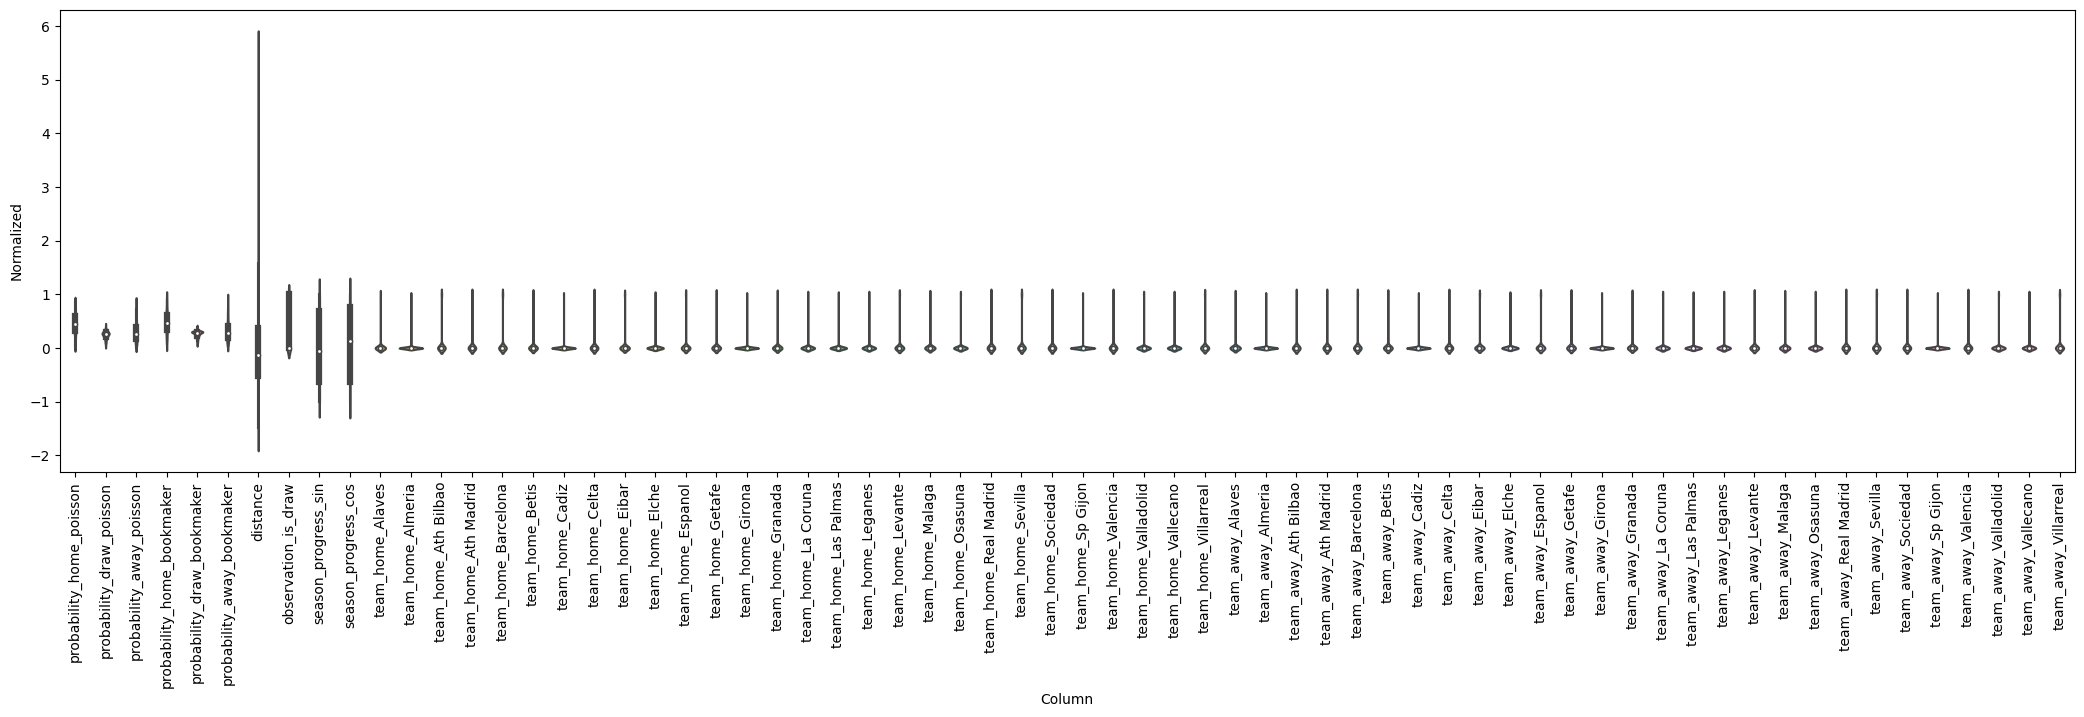

In [18]:
# Plot for checking if data has been correctly normalized.

df_std = df.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(26, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)
df_std

# Split

In [19]:
features = df.drop(columns=['observation_is_draw'])
labels = df[['observation_is_draw']]

In [20]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features, labels, test_size=0.2, random_state=0)

# Model

## Architecture

In [21]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1024, activation='relu'),
    tf.keras.layers.Dense(units=512, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

2022-11-29 23:04:14.974186: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-11-29 23:04:14.974584: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-11-29 23:04:14.974614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (alberto-czapka-portatil): /proc/driver/nvidia/version does not exist
2022-11-29 23:04:14.975587: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    metrics=[
        'accuracy', 
        tf.keras.metrics.Precision(),
        tf.keras.metrics.AUC()
    ],
)

In [23]:
# Imbalanced learning: data weights.

total = len(df)
pos = df['observation_is_draw'].sum()
neg = len(df)-df['observation_is_draw'].sum()

# Scaling by total/2 helps keep the loss to a similar magnitude. The sum of the weights of all examples stays the same.

weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.67
Weight for class 1: 1.99


## Training

In [24]:
history = model.fit( 
    x=features_train,
    y=labels_train,
    validation_data=[features_validation, labels_validation],
    batch_size=32,
    epochs=50,
    class_weight=class_weight,
    verbose=0,
)

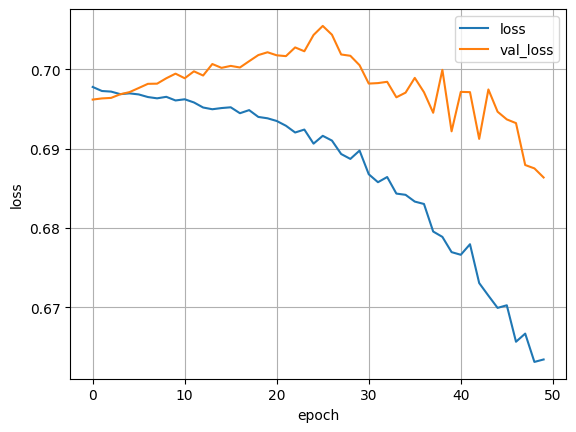

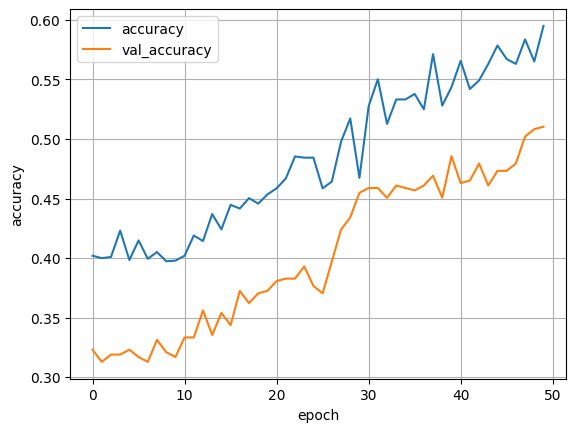

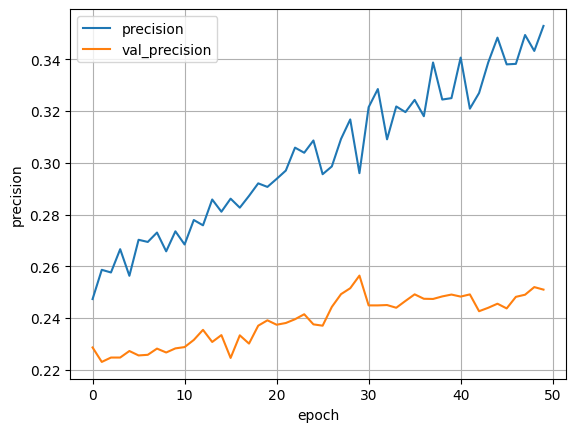

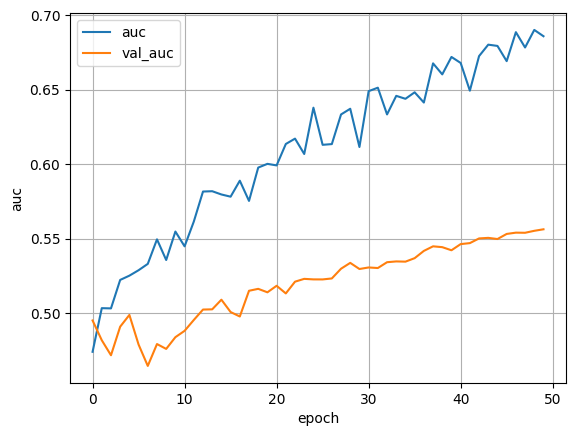

In [25]:
for metric in history.history.keys():
    if metric[:4] == 'val_':
        continue
    plt.plot(history.history[metric])
    try:
        plt.plot(history.history['val_'+metric])
        plt.legend([metric, 'val_'+metric])
    except:
        plt.legend([metric])
    plt.xlabel("epoch")
    plt.ylabel(metric)
    plt.grid(True)
    plt.show()

## Validation

In [26]:
# Validation metrics.

weighted_results = model.evaluate(
    features_validation, 
    labels_validation,
    batch_size=32, 
    verbose=0
)

for name, value in zip(model.metrics_names, weighted_results):
    print(name, ': ', value)

loss :  0.6863598823547363
accuracy :  0.5102880597114563
precision :  0.25099602341651917
auc :  0.5562053918838501


In [27]:
# Average prediction.

predictions = model.predict(features_validation)
predictions = np.round(predictions)
y_true = labels_validation
y_pred = predictions

predictions.mean()

16/16 [==============================] - 0s 3ms/step


0.5164609

In [28]:
# Confussion matrix.

print(f"Initial precision: {precision_score(y_true, y_pred)}")

Initial precision: 0.250996015936255


Text(0.5, 23.52222222222222, 'Predicted label')

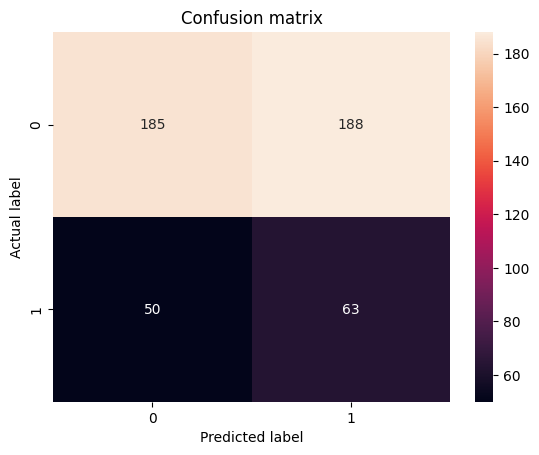

In [29]:
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [30]:
# ROC curve.

def plot_roc(name, labels, predictions, **kwargs):
    fp, tp, _ = roc_curve(labels, predictions)

    plt.plot(100*fp, 100*tp, label=name, linewidth=2, **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

16/16 [==============================] - 0s 3ms/step


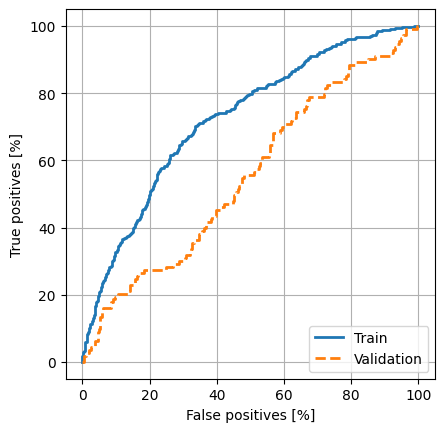

In [31]:
plot_roc("Train", labels_train, model.predict(features_train))
plot_roc("Validation", labels_validation, model.predict(features_validation), linestyle='--')
plt.legend(loc='lower right');

# Optimization of the decision threshold

## Precision optimization

In [32]:
# Precision, recall and F1.

y_true = labels_validation
y_pred = model.predict(features_validation)

precision, recall, thresholds = precision_recall_curve(y_true=y_true, probas_pred=y_pred)
precision[precision == 0] = 'nan'
recall[recall == 0] = 'nan'
f1 = 2 * (precision * recall) / (precision + recall)

16/16 [==============================] - 0s 3ms/step


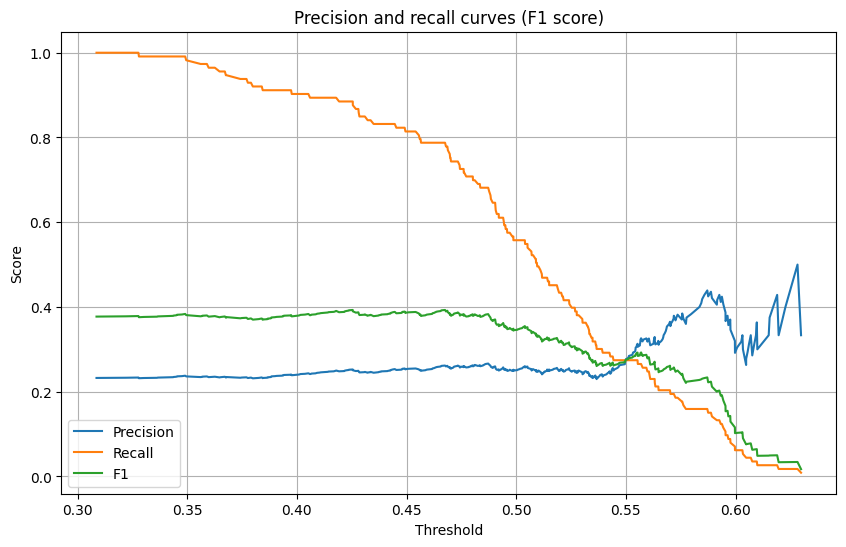

In [33]:
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.plot(thresholds, f1[:-1], label='F1')
plt.grid(True)
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and recall curves (F1 score)')
plt.legend(loc="lower left");

In [34]:
# Choosing a threshold that maximizes precision.

predictions = model.predict(features_validation)

threshold = 0.595
predictions[predictions >= threshold] = 1
predictions[predictions < threshold] = 0
predictions = predictions.astype(int)

16/16 [==============================] - 0s 3ms/step


In [35]:
print(f"Final precision: {precision_score(y_true, predictions)}")

Final precision: 0.3870967741935484


Text(0.5, 23.52222222222222, 'Predicted label')

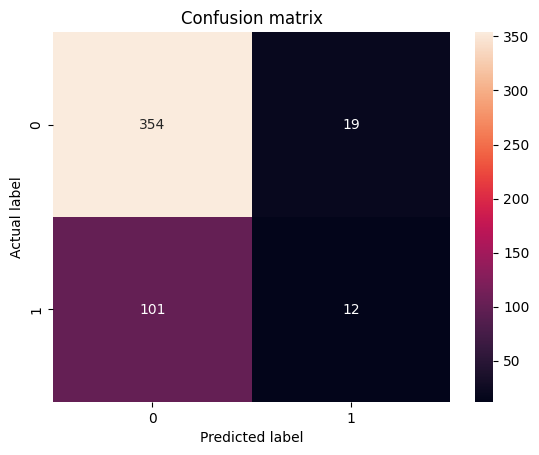

In [36]:
sns.heatmap(confusion_matrix(y_true, predictions), annot=True, fmt="d")
plt.title('Confusion matrix')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

## Final results

In [37]:
# Results of the bets on the matches of the validation dataset following the predictions of the model.

bet_amount = 100

df_results = features_validation.merge(labels_validation, left_index=True, right_index=True)

df_results['probability_draw_bookmaker'] = 1 - df_results['probability_home_bookmaker'] - df_results['probability_away_bookmaker']
df_results['bookmaker_prediction'] = 0
df_results.loc[df_results['probability_draw_bookmaker'] >= 0.5, 'bookmaker_prediction'] = 1

df_results['bookmaker_prediction_is_true'] = 0
df_results.loc[df_results['bookmaker_prediction'] == df_results['observation_is_draw'], 'bookmaker_prediction_is_true'] = 1

df_results['metamodel_prediction'] = predictions

df_results['metamodel_prediction_is_true'] = 0
df_results.loc[df_results['metamodel_prediction'] == df_results['observation_is_draw'], 'metamodel_prediction_is_true'] = 1

df_results['odds_draw_bookmaker'] = 1 / df_results['probability_draw_bookmaker']
df_results['earns'] = bet_amount * df_results['odds_draw_bookmaker'] * df_results['metamodel_prediction'] * df_results['observation_is_draw']
df_results['expenses'] = bet_amount * df_results['metamodel_prediction']
df_results['profit'] = df_results['earns'] - df_results['expenses']
df_results

,probability_home_poisson,probability_draw_poisson,probability_away_poisson,probability_home_bookmaker,probability_draw_bookmaker,probability_away_bookmaker,distance,season_progress_sin,season_progress_cos,team_home_Alaves,...,team_away_Villarreal,observation_is_draw,bookmaker_prediction,bookmaker_prediction_is_true,metamodel_prediction,metamodel_prediction_is_true,odds_draw_bookmaker,earns,expenses,profit
1387,0.320,0.301,0.379,0.444,0.253,0.303,-0.093732,0.809,0.588,0,...,1,0,0,1,0,1,3.952569,0.000000,0,0.000000
1518,0.632,0.202,0.160,0.400,0.243,0.357,0.376064,-0.876,-0.482,0,...,0,0,0,1,0,1,4.115226,0.000000,0,0.000000
2235,0.713,0.194,0.085,0.625,0.208,0.167,-0.216007,0.982,-0.187,0,...,0,0,0,1,0,1,4.807692,0.000000,0,0.000000
1312,0.444,0.274,0.281,0.735,0.132,0.133,2.860191,-0.637,0.771,0,...,0,0,0,1,0,1,7.575758,0.000000,0,0.000000
634,0.239,0.257,0.503,0.111,0.120,0.769,-0.541003,0.588,-0.809,0,...,0,1,0,0,0,0,8.333333,0.000000,0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1647,0.506,0.276,0.217,0.621,0.197,0.182,-0.100167,0.637,0.771,0,...,0,0,0,1,0,1,5.076142,0.000000,0,0.000000
1199,0.328,0.241,0.427,0.394,0.242,0.364,5.061152,-0.063,-0.998,0,...,0,0,0,1,1,0,4.132231,0.000000,100,-100.000000
1742,0.149,0.284,0.566,0.286,0.249,0.465,-0.074425,0.685,-0.729,0,...,0,1,0,0,1,1,4.016064,401.606426,100,301.606426
254,0.675,0.193,0.126,0.694,0.152,0.154,0.739673,-0.309,0.951,0,...,0,1,0,0,0,0,6.578947,0.000000,0,0.000000


In [38]:
# Conclusions

print(f"The validation dataset consist of {len(df_results)} matches:")
print(f"\t{df_results['observation_is_draw'].sum()} of them actually ended as a draw, with an average bookmaker odds of {round(df_results.loc[df_results['observation_is_draw']==1, 'odds_draw_bookmaker'].mean(), 2)}")

print(f"\nThe bookmaker predicted {df_results['bookmaker_prediction'].sum()} draws in total:")
print(f"\t{df_results.loc[df_results['bookmaker_prediction']==1, 'bookmaker_prediction_is_true'].sum()} of these positive predictions were actually true, with an average bookmaker odds of {round(df_results.loc[(df_results['bookmaker_prediction']==1) & (df_results['bookmaker_prediction_is_true']==1), 'odds_draw_bookmaker'].mean(), 2)}")

print(f"\nThe metamodel predicted {df_results['metamodel_prediction'].sum()} draws in total:")
print(f"\t{df_results.loc[df_results['metamodel_prediction']==1, 'metamodel_prediction_is_true'].sum()} of these positive predictions were actually true, with an average bookmaker odds of {round(df_results.loc[(df_results['metamodel_prediction']==1) & (df_results['metamodel_prediction_is_true']==1), 'odds_draw_bookmaker'].mean(), 2)}")

print(f"\nFollowing the metamodel predictions and with an individual bet of {bet_amount}, the total money spent on bets would be {df_results['expenses'].sum()}:")
print(f"\tbut the total earnings would be {round(df_results['earns'].sum())}")

print("\n\n----------------------------------------------------------------")
print(f"Final total profit following the metamodel predictions: {round(df_results['profit'].sum())}")
print(f"\tOn average, each bet returned {round(df_results['earns'].sum()/df_results['expenses'].sum(), 2)} times the money spent")
print("----------------------------------------------------------------\n")

The validation dataset consist of 486 matches:
	113 of them actually ended as a draw, with an average bookmaker odds of 4.78

The bookmaker predicted 0 draws in total:
	0 of these positive predictions were actually true, with an average bookmaker odds of nan

The metamodel predicted 31 draws in total:
	12 of these positive predictions were actually true, with an average bookmaker odds of 3.89

Following the metamodel predictions and with an individual bet of 100, the total money spent on bets would be 3100:
	but the total earnings would be 4665


----------------------------------------------------------------
Final total profit following the metamodel predictions: 1565
	On average, each bet returned 1.5 times the money spent
----------------------------------------------------------------

